# Homework 6: Stock Prediction

The first part of this notebook outlines a general process for stock prediction using tensorflow. Your assignment really starts further down and feel free to use pytorch or tensorflow for designing your own algorthm in part 2.

Items to turn in: 
 1. your completed notebook as a .pdf (only one file, do not separate into multiple)  
 2. a zip folder with the following:
 - your .ipynb file
 - your saved model (pytorch or tensorflow)
 - your data as a .txt or .csv

## GE Stock Prediction
Here we are going to predict GE stock prices. Example from https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

In [240]:
# Import Required Libraries
# Graph Functions
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
import pandas as pd
import os

## Import and Inspect Data

In [241]:
display(os.getcwd())
df_ge = pd.read_csv('ge_stock.txt', engine='python')
df_ge.tail()

'C:\\Users\\chari\\Downloads'

,Date,Open,High,Low,Close,Volume,OpenInt
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,0
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,0
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,0


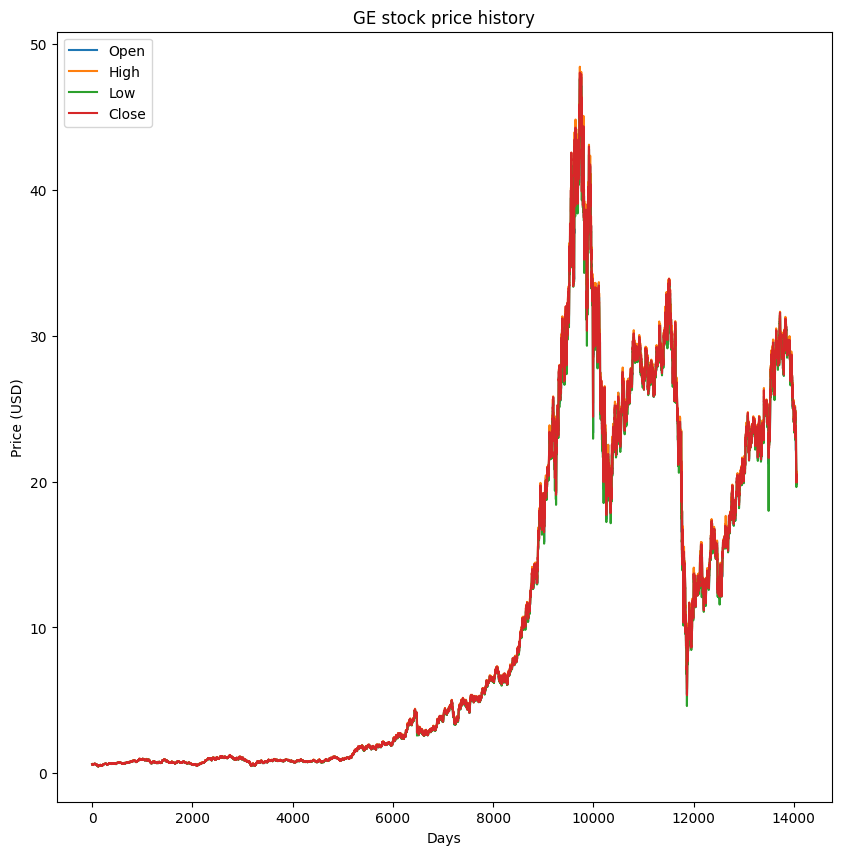

In [242]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

## Preprocess the Data
We need to normalize the data in order to improve convergence time.

In [243]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
#train_cols = ["Open","High","Low","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

# Train scalar only on Y
stock_min_max = MinMaxScaler()
stock_min_max.fit_transform(np.reshape(df_train.loc[:, "Close"].values, (-1, 1)))

Train and Test size 11246 2812


C:\Users\chari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


array([[0.00338425],
       [0.00338425],
       [0.00321827],
       ...,
       [0.56564471],
       [0.57270398],
       [0.57677987]])

## Reshape the Data for Training
Our current dataset is not in a form suitable for training.

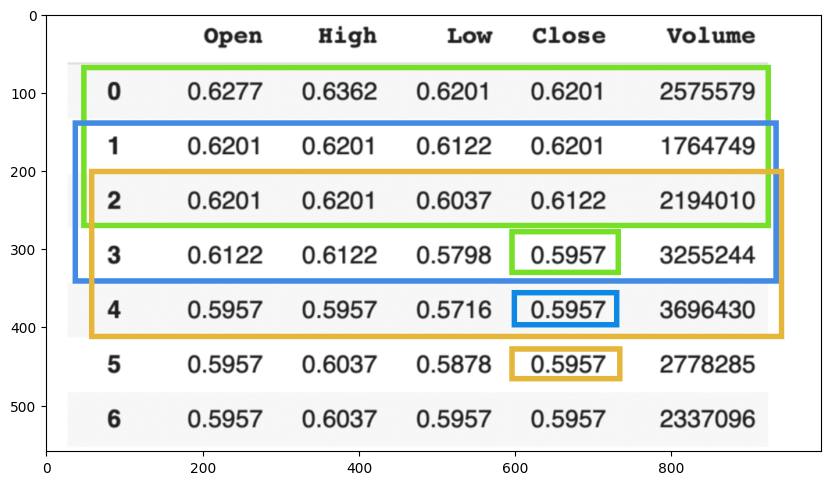

In [244]:
import matplotlib.image as mpimg
img = mpimg.imread('stock_training.png')
plt.imshow(img)

In [245]:
def build_timeseries(mat, y_col_index, TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0-4):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i+4, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat


In [246]:
TIME_STEPS = 3
BATCH_SIZE = 32
x_t, y_t = build_timeseries(x_train, 3, TIME_STEPS)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3, TIME_STEPS)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (11243, 3, 5) (11243,)
length of time-series i/o (2809, 3, 5) (2809,)


## Model Creation
Time to create our Keras Model

In [247]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [248]:
# Import functions from Keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, InputLayer, Input

In [249]:
lstm_model = Sequential()
lstm_model.add(InputLayer(batch_input_shape = (BATCH_SIZE, TIME_STEPS, 
                                            x_t.shape[2])))
lstm_model.add(LSTM(100, stateful = True, dropout=0.0, recurrent_dropout=0.0))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='linear'))
lstm_model.compile(loss='mean_squared_error', 
                   optimizer='sgd',
                   metrics=['mae'])

In [250]:
lstm_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (32, 100)                   │          42,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (32, 100)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (32, 20)                    │           2,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (32, 1)                     │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,441 (173.60 KB)

 Trainable params: 44,441 (173.60 KB)

 Non-trainable params: 0 (0.00 B)

# Plot Model
The following code is to plot your created model. If you do not have certain outside libraries installed, the code may not run. This is Okay. You do not need this code to do the assignment.

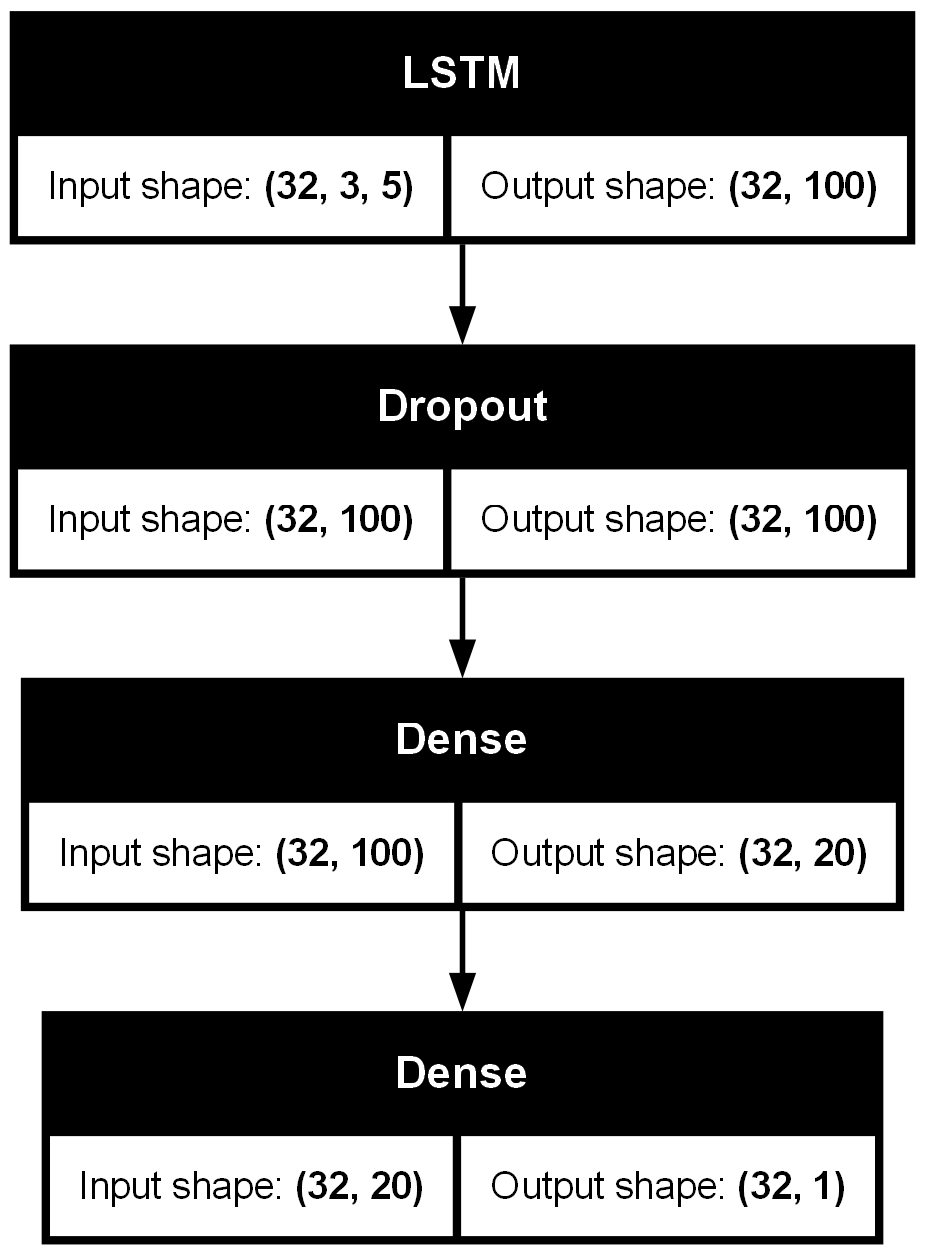

In [251]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
#from keras.utils import model_to_dot
plot_model(lstm_model, show_shapes = True)

# Train and Plot Model Performance

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0449 - mae: 0.1459 - val_loss: 0.0026 - val_mae: 0.0381
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - mae: 0.0838 - val_loss: 0.0067 - val_mae: 0.0637
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - mae: 0.0730 - val_loss: 0.0083 - val_mae: 0.0719
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084 - mae: 0.0662 - val_loss: 0.0075 - val_mae: 0.0682
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070 - mae: 0.0601 - val_loss: 0.0058 - val_mae: 0.0589
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - mae: 0.0534 - val_loss: 0.0054 - val_mae: 0.0562
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0053 - mae: 0.0497 - val_loss: 0.0046 - val_mae: 0.0509
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044 - mae: 0.0453 - val_loss: 0.0042 - val_mae: 0.0484
Epoch 9/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

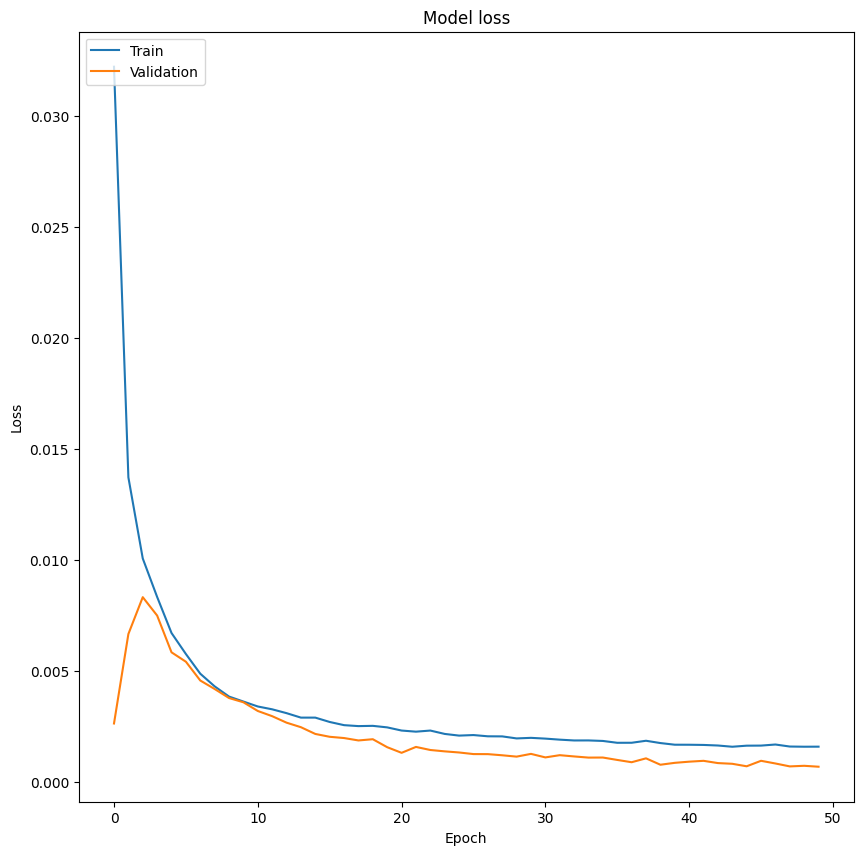

In [252]:
history = lstm_model.fit(x_t, y_t,
          batch_size=32, epochs=50, verbose=1,
          validation_data=(trim_dataset(x_val, BATCH_SIZE), 
                           trim_dataset(y_val, BATCH_SIZE)))

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Generate Performance Metrics

In [253]:
score = lstm_model.evaluate(x_t, y_t, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1] )

351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6780e-04 - mae: 0.0116
Test score: 0.0003229662252124399
Test accuracy: 0.013868317008018494


# Plot Validation Data against Actual

In [254]:
predicted = lstm_model.predict(trim_dataset(x_val, BATCH_SIZE))
display(predicted)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


array([[0.58686155],
       [0.58596474],
       [0.5847907 ],
       ...,
       [0.3536986 ],
       [0.35351253],
       [0.35258877]], dtype=float32)

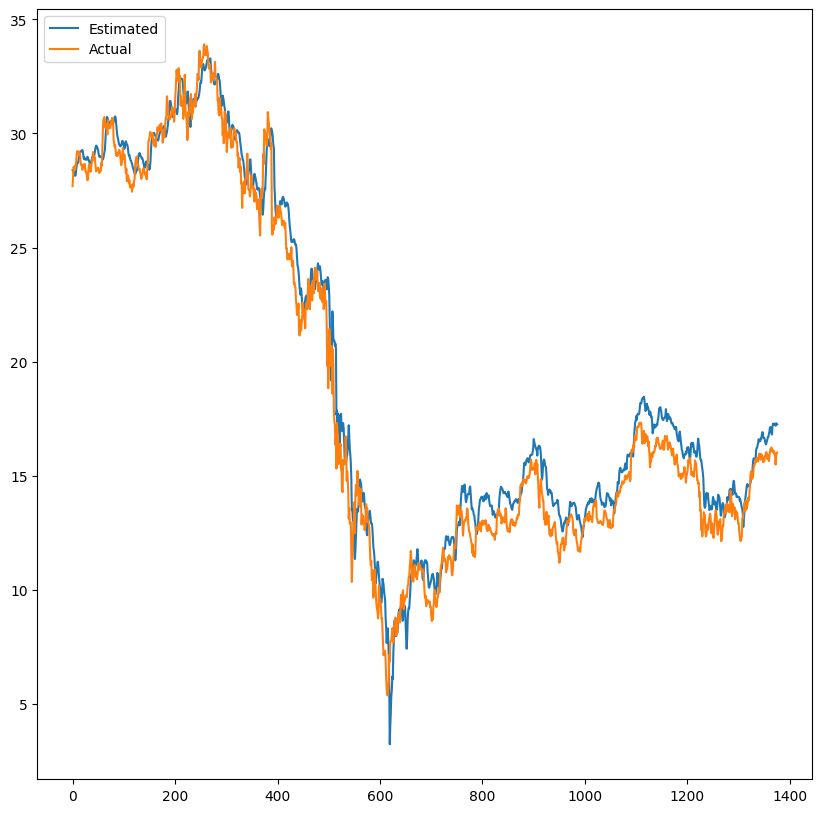

In [255]:
plt.figure()
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')

## Question 1: Changing Hyperparameters
Keras comes with pre-implemented loss functions and optimizers:

- Loss Function => https://keras.io/losses/
- Optimizer     => https://keras.io/optimizers/
         
Please pick two loss functions and two optimizers (for a total of four combinations) and compare their results using 10 epochs. Include a plot of the actual stock values and the predicted values for each combination and comment your observation.



Optimizers used - Adaptive Moment Estimation with weight decay (AdamW) and Root Mean Square Propagation (RMSProp) <br>
Loss Functions used - Huber Loss and Mean Absolute Error

In [256]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import Huber, MeanAbsoluteError

In [257]:
def train(model, x_train, y_train, x_val, y_val, epochs=10):
    history = model.fit(x_train, y_train, batch_size=32, epochs=epochs, verbose=1,
                        validation_data=(trim_dataset(x_val, BATCH_SIZE), trim_dataset(y_val, BATCH_SIZE)))
    
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [258]:
def estimated_actual_plot(model, x_val, y_val, stock_min_max):
    score = model.evaluate(x_t, y_t, verbose=1)
    print('Test score:', score[0])
    print('Test accuracy:', score[1] )

    predicted = model.predict(trim_dataset(x_val, BATCH_SIZE))
    
    plt.figure()
    plt.plot(stock_min_max.inverse_transform(predicted))
    plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1,1))))
    plt.legend(['Estimated', 'Actual'], loc='upper left')
    plt.title('Actual vs Predicted Stock Prices')
    plt.show()

In [259]:
#define the loss functions and the optimizers
loss_functions = [tf.keras.losses.Huber(), tf.keras.losses.MeanAbsoluteError()]
optimizers = [tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
             tf.keras.optimizers.RMSprop(learning_rate=0.001)]

Training with Loss Function: Huber, Optimizer: AdamW
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.1317e-04 - mae: 0.0224 - val_loss: 3.1660e-04 - val_mae: 0.0170
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4793e-04 - mae: 0.0163 - val_loss: 5.0046e-04 - val_mae: 0.0269
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4234e-04 - mae: 0.0155 - val_loss: 3.9883e-04 - val_mae: 0.0228
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.0697e-04 - mae: 0.0150 - val_loss: 2.7300e-04 - val_mae: 0.0177
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7578e-04 - mae: 0.0145 - val_loss: 2.1049e-04 - val_mae: 0.0151
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4006e-04 - mae: 0.0135 - val_loss: 5.8175e-04 - val_mae: 0.0259
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4950e-04 - mae: 0.0138 - val_loss: 2.6681e-04 - val_mae: 0.0167
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.428

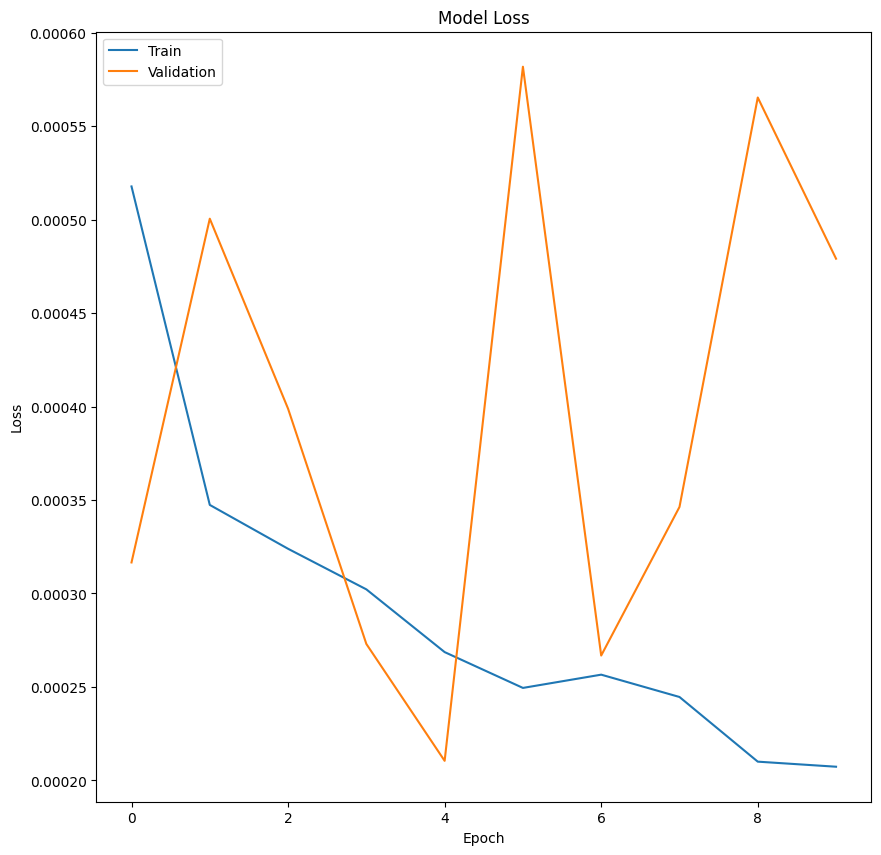

351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6945e-05 - mae: 0.0028     
Test score: 0.00011367481056367978
Test accuracy: 0.0074210562743246555
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


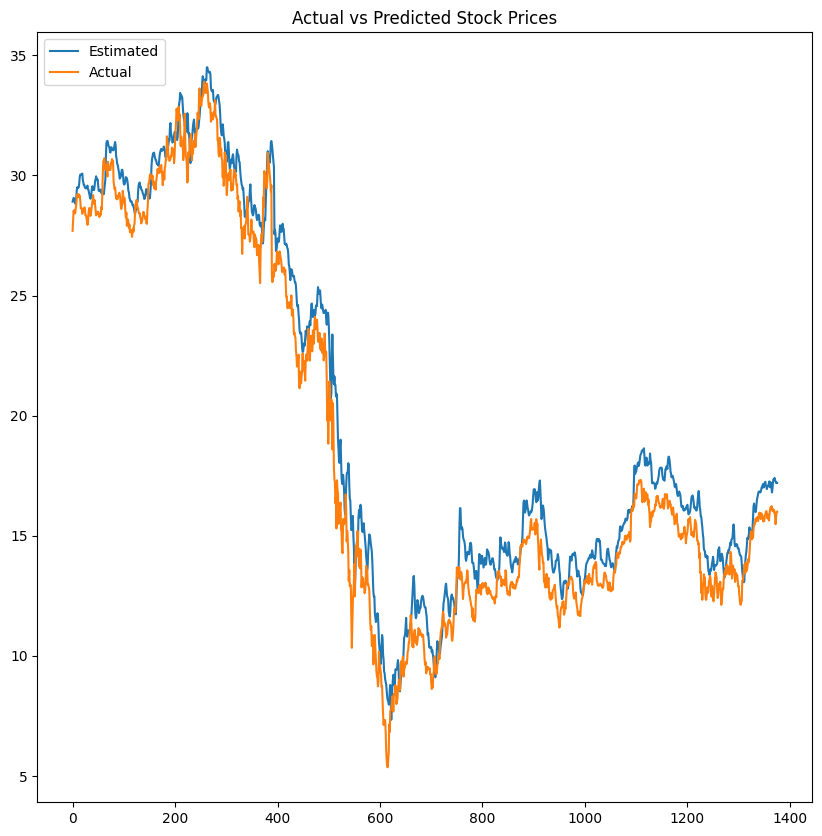

Training with Loss Function: MeanAbsoluteError, Optimizer: AdamW
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0196 - mae: 0.0196 - val_loss: 0.0224 - val_mae: 0.0224
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - mae: 0.0119 - val_loss: 0.0226 - val_mae: 0.0226
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0252 - val_mae: 0.0252
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - mae: 0.0111 - val_loss: 0.0185 - val_mae: 0.0185
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0184 - val_mae: 0.0184
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0100 - mae: 0.0100 - val_loss: 0.0163 - val_mae: 0.0163
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098 - mae: 0.0098 - val_loss: 0.0174 - val_mae: 0.0174
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0096 - mae: 0.0096 - val_loss: 0.0182 - val_mae

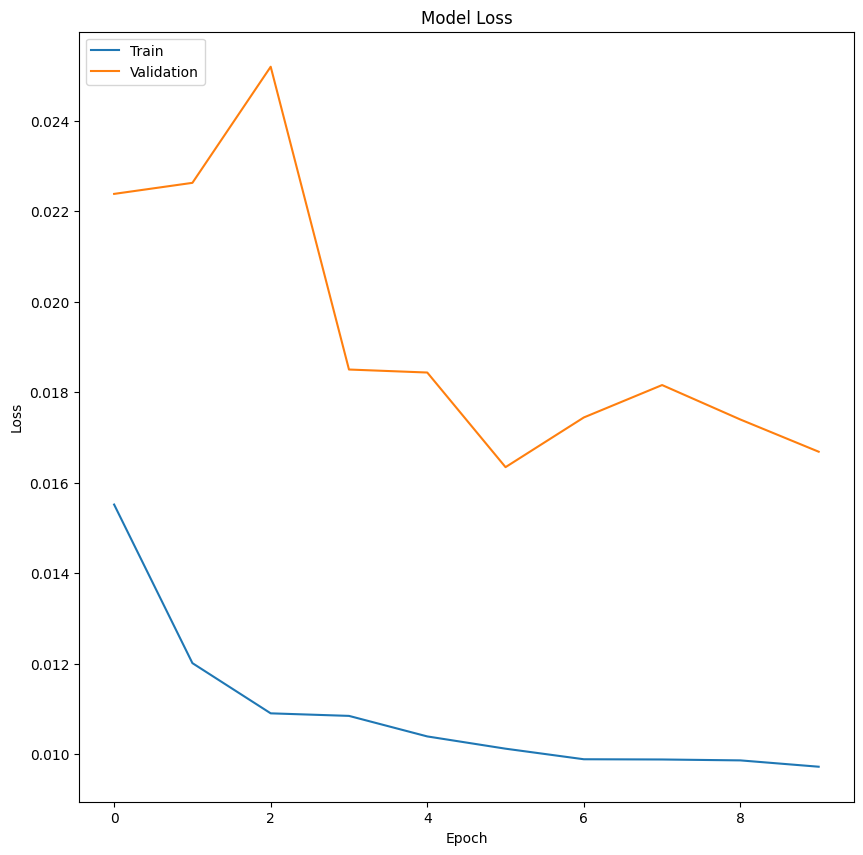

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 - mae: 0.0038 
Test score: 0.007443047594279051
Test accuracy: 0.007443047594279051
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


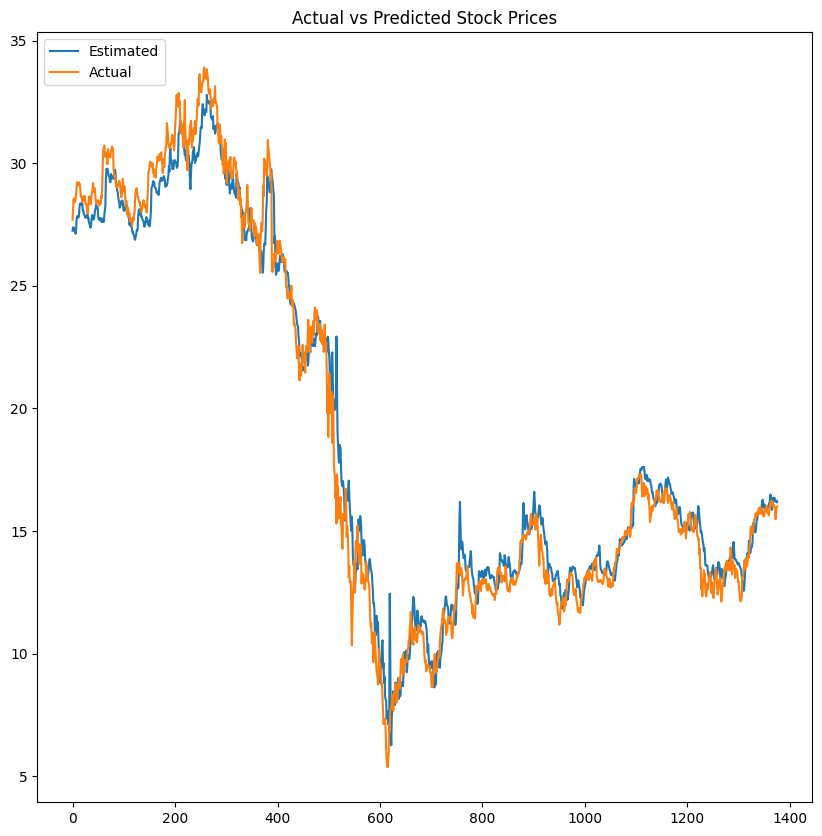

Training with Loss Function: Huber, Optimizer: RMSprop
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5070e-04 - mae: 0.0091 - val_loss: 3.6500e-04 - val_mae: 0.0207
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5627e-04 - mae: 0.0093 - val_loss: 2.4138e-04 - val_mae: 0.0157
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5588e-04 - mae: 0.0094 - val_loss: 4.2782e-04 - val_mae: 0.0225
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4944e-04 - mae: 0.0093 - val_loss: 3.2504e-04 - val_mae: 0.0186
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4115e-04 - mae: 0.0091 - val_loss: 3.3780e-04 - val_mae: 0.0188
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4477e-04 - mae: 0.0094 - val_loss: 4.3308e-04 - val_mae: 0.0223
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4166e-04 - mae: 0.0093 - val_loss: 3.5748e-04 - val_mae: 0.0191
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4

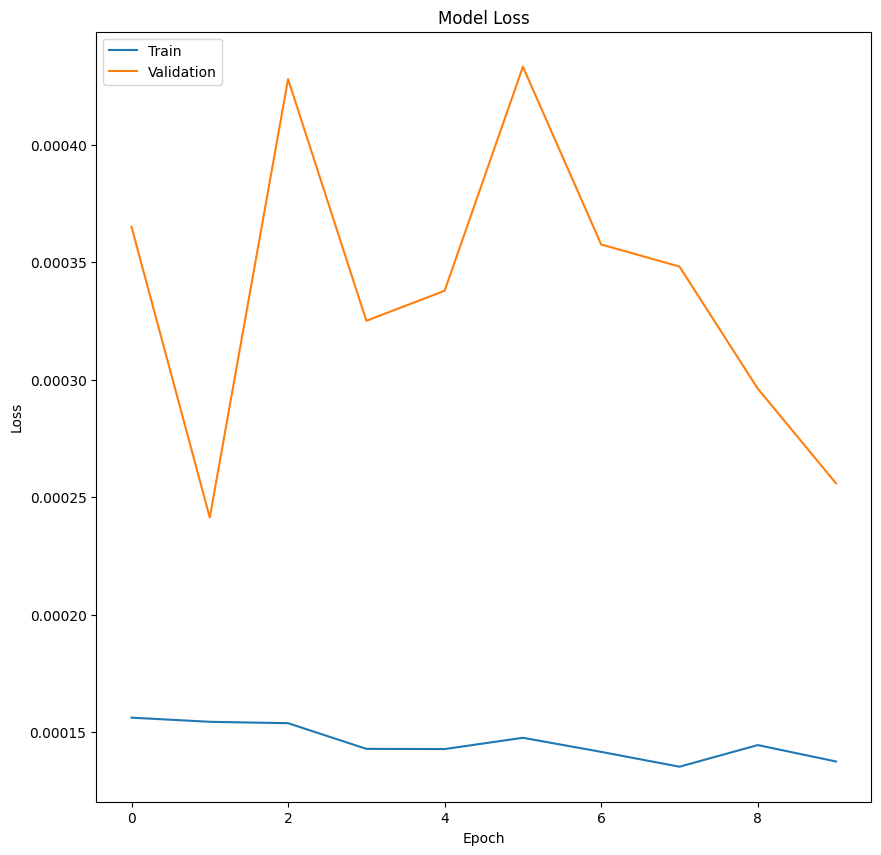

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1711e-05 - mae: 0.0013     
Test score: 8.050711767282337e-05
Test accuracy: 0.00523849343881011
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


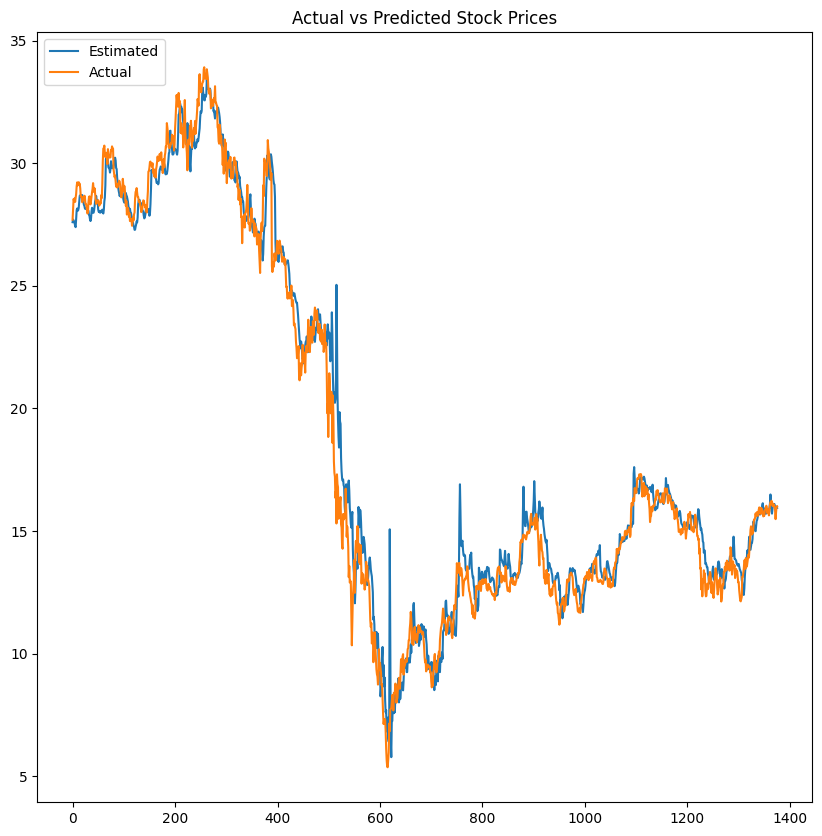

Training with Loss Function: MeanAbsoluteError, Optimizer: RMSprop
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0115 - mae: 0.0115 - val_loss: 0.0166 - val_mae: 0.0166
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - mae: 0.0114 - val_loss: 0.0178 - val_mae: 0.0178
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112 - mae: 0.0112 - val_loss: 0.0131 - val_mae: 0.0131
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0171 - val_mae: 0.0171
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - mae: 0.0113 - val_loss: 0.0158 - val_mae: 0.0158
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - mae: 0.0109 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - mae: 0.0109 - val_loss: 0.0145 - val_mae: 0.0145
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0143 - val_m

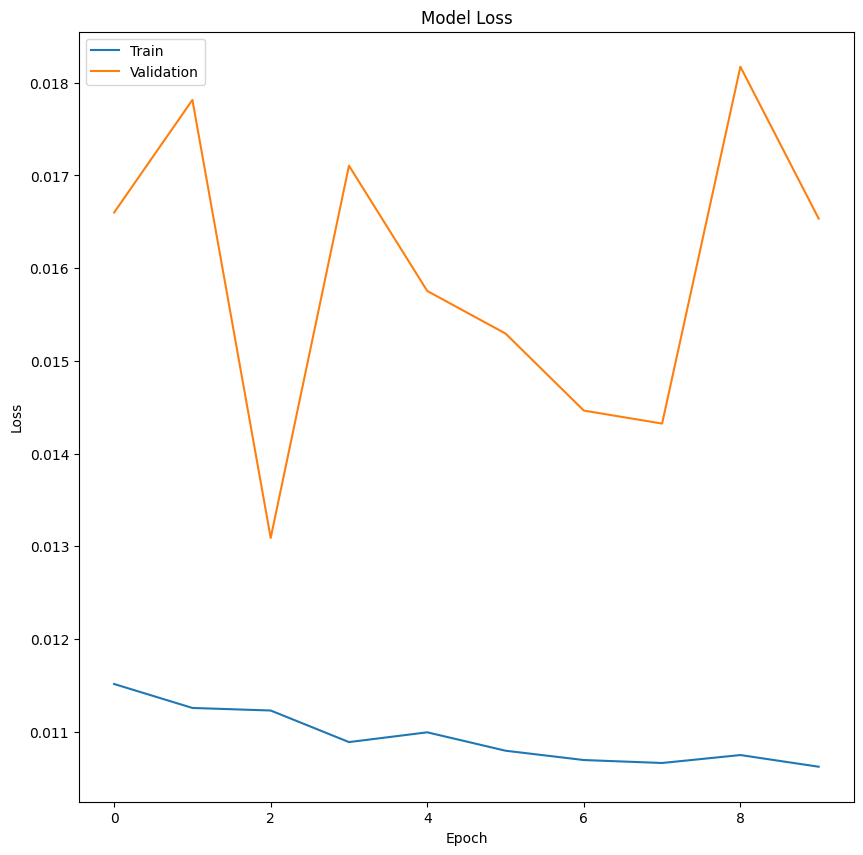

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - mae: 0.0034 
Test score: 0.007598478812724352
Test accuracy: 0.007598478812724352
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


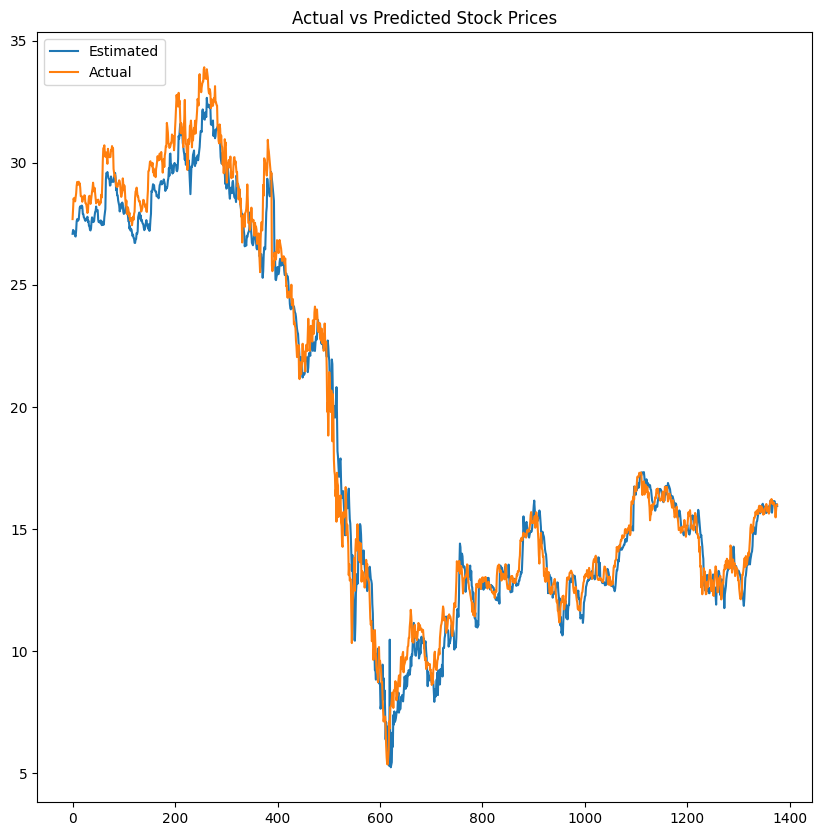

In [260]:
# Run experiments for 4 combinations
for opt in optimizers:
    for loss in loss_functions:
        print(f"Training with Loss Function: {loss.__class__.__name__}, Optimizer: {opt.__class__.__name__}")
        
        lstm_model.compile(loss=loss, optimizer=opt, metrics=['mae'])
        train(lstm_model, x_t, y_t, x_val, y_val, epochs=10)
        estimated_actual_plot(lstm_model, x_val, y_val, stock_min_max)

## Fill in the table here

| Optimizer | Loss | Observations|
|-----------|------|-------------|
| AdamW| Huber Loss| The testing accuracy decreased when compared to the combination of SGD optimizer and MSE loss. But, from the actual vs. predicted plot, it is observed that predicted curve and actual curve show strong alignment with each other. This means that there are more correct predictions which shows that this combination has strong predictive efficiency and generalization performance. Training loss showed a slow decrease where as validation loss showed fluctutions initially and then increased rapidly.|
| AdamW| Mean absolute error| For AdamW optimizer, the mean absolute error showed strong alignment between actual and predicted curves than with the Huber loss. This means that mean absolute error as a loss function was more effective in minimizing the prediction deviation leading to accurate forecasts. The test accuracy is almost the same for both the loss functions. |
| RMSProp| Huber Loss| From the actual and predicted curves, I noticed that RMSProp and Huber Loss showed string alignment compared to the first two combinations. When examining the loss curves, both the training loss and validation loss exhibited fluctuations throughout the training process. Training loss showed relatively minimal fluctuations.|
| RMS Prop| Mean absolute error| The alignment of actual and predicted curves is slightly better than the combination of SGD optimizer and MSE loss function. But, its showed less alignment compared to the above three combinations. |

In conclusion, the combination of Huber loss and RMSProp optimizer showed best efficieny among all. This is evident from the strong alignment in actual and predicted curves, demostrating string generalization performance.

# Problem 2: Create Your Own Stock Prediction Algorithm
Follow similar steps to the above code, but for your own algorithm. Choose any stock and collect the data yourself (yahoo stocks is a good site).  

Create your own deep learning architecture to predict future stock prices for **Thirty days** and **1 Year into the future**. Note: the example above only predicted the next day’s stock value. You are not limited to the feature extraction, preprocessing, or validation process used in part 1. Be creative! 

Briefly describe why you chose the deep learning architecture you used, along with reasons for choosing the number of epochs, optimizer, activation functions, number of neurons in each layer, batch size, and the validation methodology.

Please turn in a .txt or .csv file that contains the data and your saved model.

I am using Amazon stock data from yfinance from 2010 to today.

In [261]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, SimpleRNN, Dropout, Dense, BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [262]:
import yfinance as yf
import pandas as pd
from datetime import datetime

stock_symbol = 'AMZN'

end_date = datetime.today().strftime('%Y-%m-%d')

data = yf.download(stock_symbol, start='2010-01-01', end=end_date)

print(data.head())

data.to_csv('HW6_amazon.csv')

[*********************100%***********************]  1 of 1 completed

Price        Close    High     Low    Open     Volume
Ticker        AMZN    AMZN    AMZN    AMZN       AMZN
Date                                                 
2010-01-04  6.6950  6.8305  6.6570  6.8125  151998000
2010-01-05  6.7345  6.7740  6.5905  6.6715  177038000
2010-01-06  6.6125  6.7365  6.5825  6.7300  143576000
2010-01-07  6.5000  6.6160  6.4400  6.6005  220604000
2010-01-08  6.6760  6.6840  6.4515  6.5280  196610000


In [263]:
if 'Date' in data.columns:
    data.drop(columns=['Date'], inplace=True)

In [264]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2010-01-04,6.6950,6.8305,6.6570,6.8125,151998000
2010-01-05,6.7345,6.7740,6.5905,6.6715,177038000
2010-01-06,6.6125,6.7365,6.5825,6.7300,143576000
2010-01-07,6.5000,6.6160,6.4400,6.6005,220604000
2010-01-08,6.6760,6.6840,6.4515,6.5280,196610000


In [265]:
df = pd.read_csv('HW6_amazon.csv')

In [266]:
df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
1,Date,NaN,NaN,NaN,NaN,NaN
2,2010-01-04,6.695000171661377,6.83050012588501,6.6570000648498535,6.8125,151998000
3,2010-01-05,6.734499931335449,6.77400016784668,6.5904998779296875,6.671500205993652,177038000
4,2010-01-06,6.612500190734863,6.736499786376953,6.582499980926514,6.730000019073486,143576000


In [267]:
if 'Price' in df.columns:
    df.drop(columns=['Price'], inplace=True)

In [268]:
df.head()

,Close,High,Low,Open,Volume
0,AMZN,AMZN,AMZN,AMZN,AMZN
1,NaN,NaN,NaN,NaN,NaN
2,6.695000171661377,6.83050012588501,6.6570000648498535,6.8125,151998000
3,6.734499931335449,6.77400016784668,6.5904998779296875,6.671500205993652,177038000
4,6.612500190734863,6.736499786376953,6.582499980926514,6.730000019073486,143576000


In [269]:
df = df.drop([0, 1])
df.head()

,Close,High,Low,Open,Volume
2,6.695000171661377,6.83050012588501,6.6570000648498535,6.8125,151998000
3,6.734499931335449,6.77400016784668,6.5904998779296875,6.671500205993652,177038000
4,6.612500190734863,6.736499786376953,6.582499980926514,6.730000019073486,143576000
5,6.5,6.616000175476074,6.440000057220459,6.600500106811523,220604000
6,6.676000118255615,6.684000015258789,6.451499938964844,6.5279998779296875,196610000


In [270]:
df = df.reset_index(drop=True)

In [271]:
df.head()

,Close,High,Low,Open,Volume
0,6.695000171661377,6.83050012588501,6.6570000648498535,6.8125,151998000
1,6.734499931335449,6.77400016784668,6.5904998779296875,6.671500205993652,177038000
2,6.612500190734863,6.736499786376953,6.582499980926514,6.730000019073486,143576000
3,6.5,6.616000175476074,6.440000057220459,6.600500106811523,220604000
4,6.676000118255615,6.684000015258789,6.451499938964844,6.5279998779296875,196610000


In [272]:
X_data = df.values

In [273]:
y_data = df[['Close']].values

In [274]:
input_len = 60
output_len = 365
val_days = 395  # 30 + 365

X_train_raw = X_data[:-(val_days + input_len)]
y_train_raw = y_data[:-(val_days + input_len)]

X_val_raw = X_data[-(val_days + input_len):]
y_val_raw = y_data[-(val_days + input_len):]

In [275]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train_raw)
y_train_scaled = y_scaler.fit_transform(y_train_raw)

X_val_scaled = X_scaler.transform(X_val_raw)
y_val_scaled = y_scaler.transform(y_val_raw)

In [276]:
def create_sequences(X, y, input_len, output_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - input_len - output_len):
        X_seq.append(X[i:i+input_len])
        y_seq.append(y[i+input_len:i+input_len+output_len])
    return np.array(X_seq), np.array(y_seq)

In [277]:
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, input_len, output_len)
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], input_len, X_train_seq.shape[2]))

In [278]:
X_train_seq.shape

(2960, 60, 5)

In [279]:
X_val_seq.shape

(30, 60, 5)

In [280]:
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, input_len, output_len)
X_val_seq = X_val_seq.reshape((X_val_seq.shape[0], input_len, X_val_seq.shape[2]))

In [281]:
def BuildModel(rate = 0.4, n_features = 365):
  model = Sequential()
  model.add(GRU(256, return_sequences=True, input_shape=(input_len, X_train_seq.shape[2])))
  model.add(Dropout(rate))
  model.add(LSTM(256))
  model.add(Dropout(rate))
  model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(n_features)) 
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
  return model

In [282]:
hybrid_model = BuildModel(0.4, 365)

C:\Users\chari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


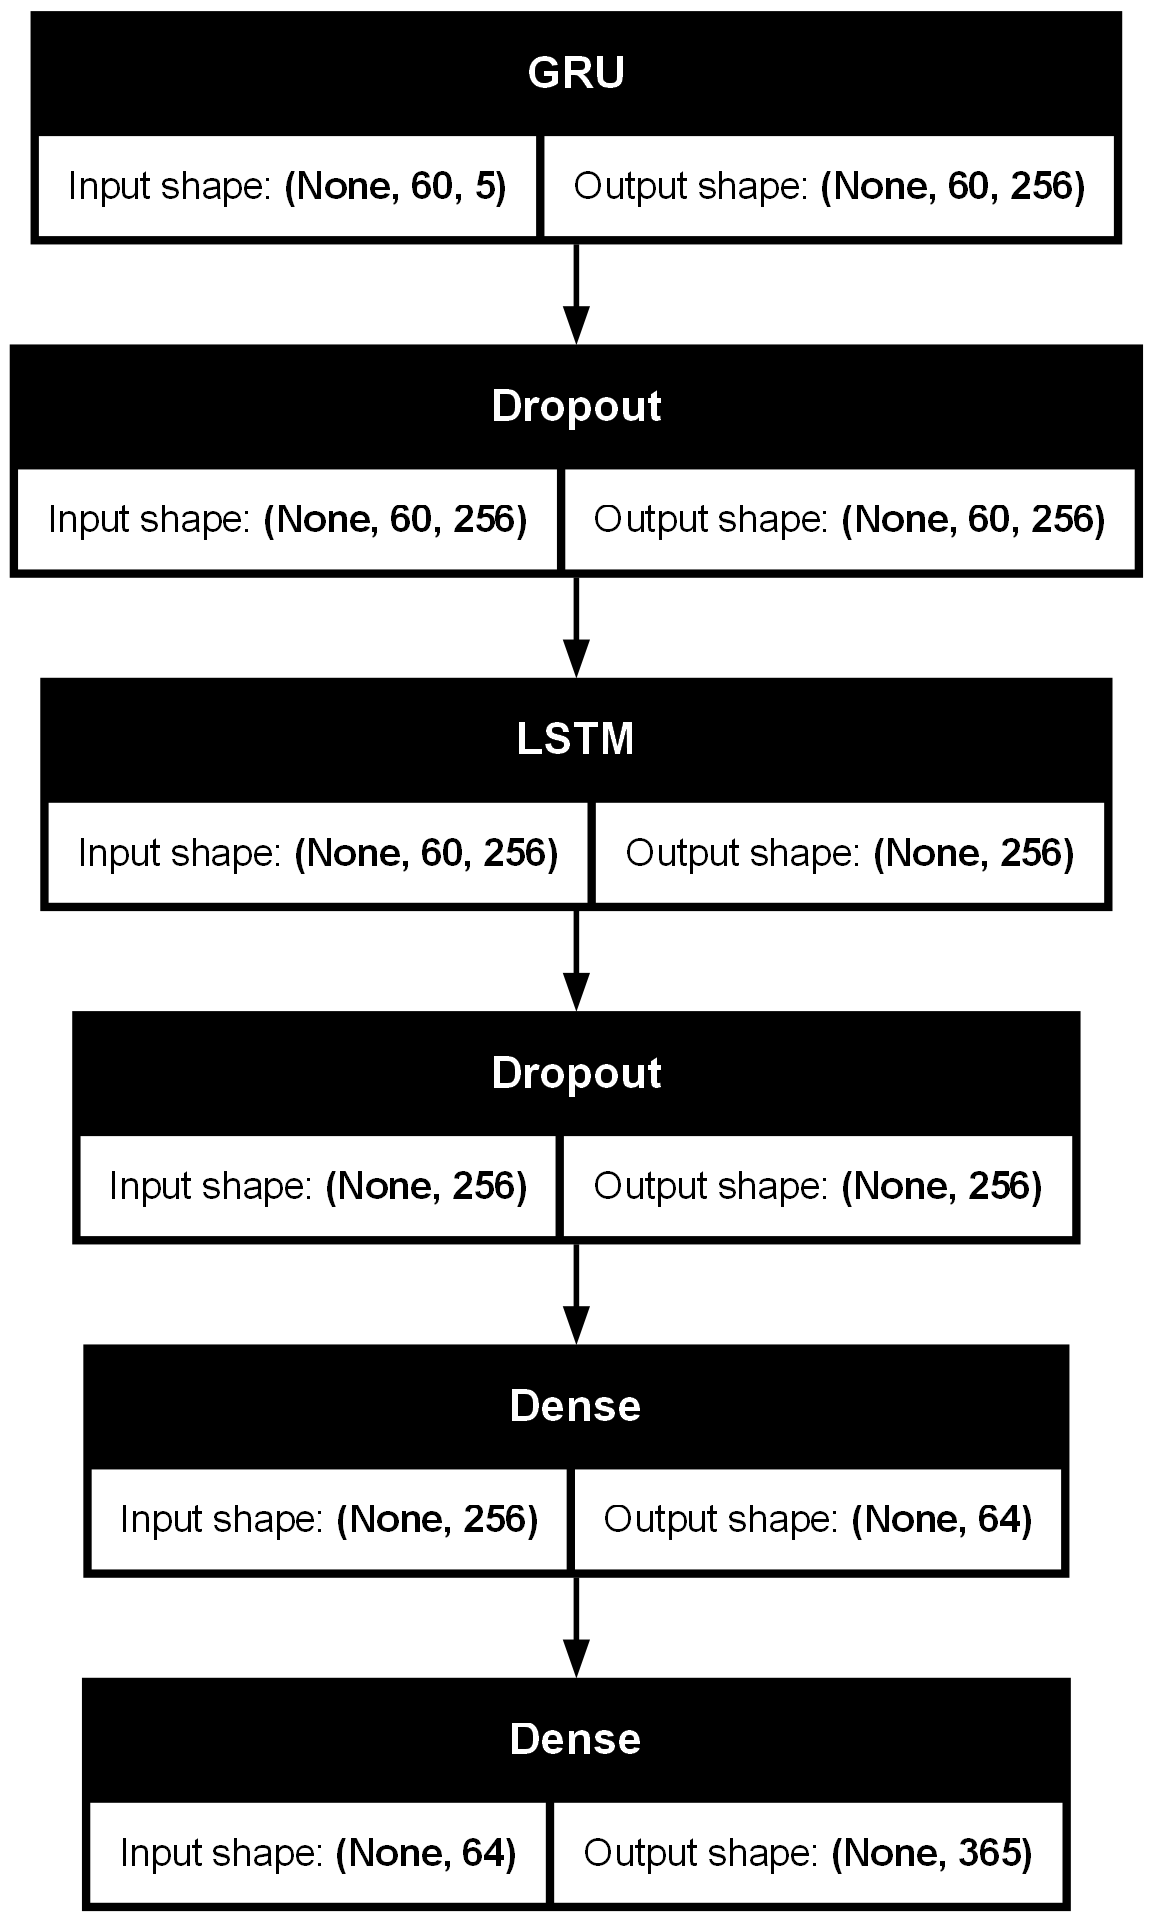

In [283]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
#from keras.utils import model_to_dot
plot_model(hybrid_model, show_shapes = True)

In [284]:
#model.compile(optimizer=RMSprop(learning_rate=0.001), loss=Huber())

In [285]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_first = hybrid_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.0739 - mean_squared_error: 0.0739 - val_loss: 0.0958 - val_mean_squared_error: 0.0958
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0616 - val_mean_squared_error: 0.0616
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0222 - val_mean_squared_error: 0.0222
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0435 - val_mean_squared_error: 0.0435
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_los

In [286]:
hybrid_model.save('HW6_model_30_365.h5')

In [287]:
from tensorflow.keras.models import load_model
##To load the model
## hybrid_model = load_model('HW6_model_30_365.h5')

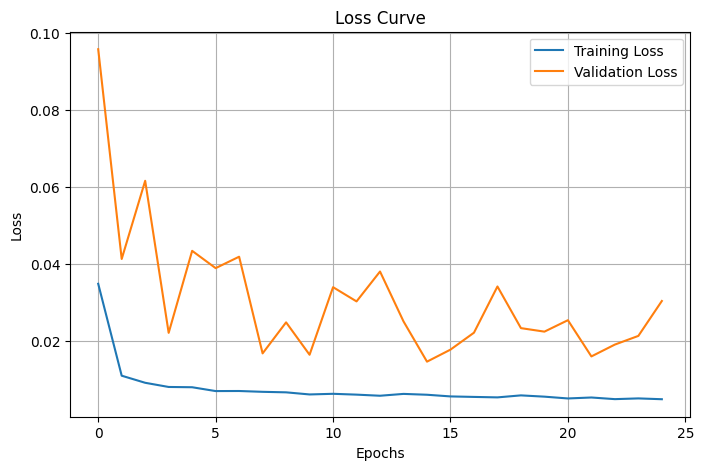

In [288]:
plt.figure(figsize=(8,5))
plt.plot(history_first.history['loss'], label='Training Loss')
plt.plot(history_first.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [289]:
X_val_scaled.shape[1]

5

In [290]:
final_input.shape

(1, 60, 5)

In [291]:
final_input = X_val_scaled[:input_len].reshape(1, input_len, X_val_scaled.shape[1])
y_pred_scaled = hybrid_model.predict(final_input)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


In [292]:
y_true_scaled = y_val_scaled[input_len:input_len + output_len]
y_true = y_scaler.inverse_transform(y_true_scaled).flatten()

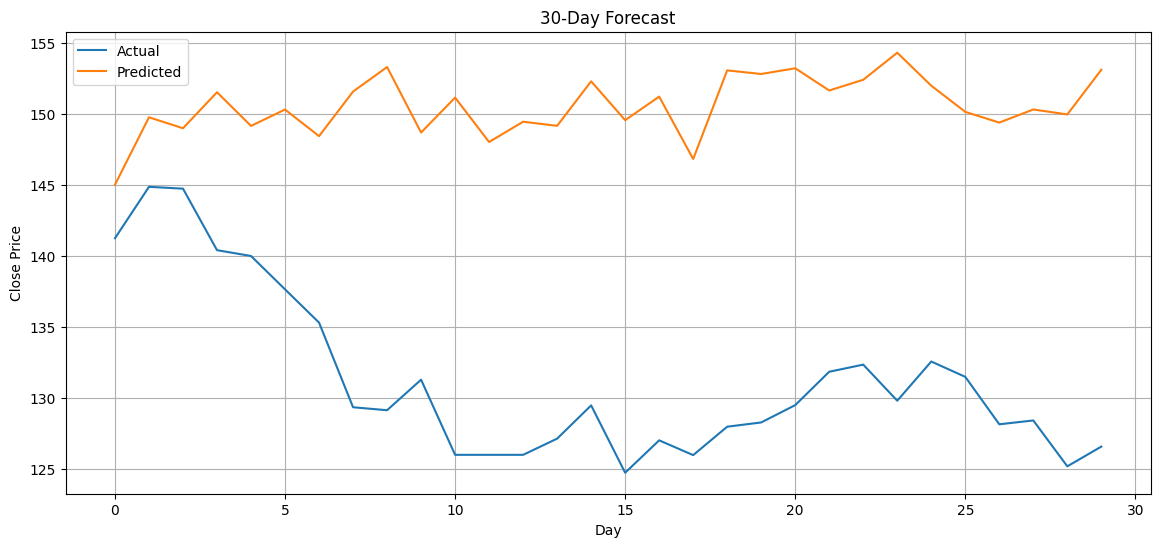

In [293]:
plt.figure(figsize=(14, 6))
plt.plot(y_true[:30], label='Actual')
plt.plot(y_pred[:30], label='Predicted')
plt.title('30-Day Forecast')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

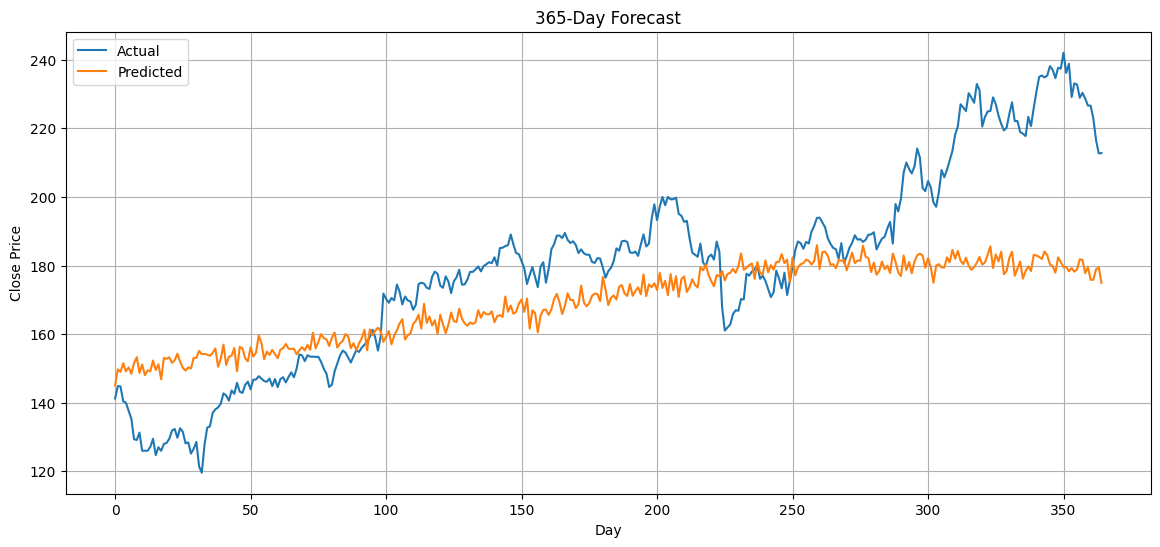

In [294]:
plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('365-Day Forecast')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

#### 1. Justification for the deep architecture (GRU-LSTM) 
GRU (Gated Recurrent Unit) is more memory and time efficient compared to LSTM but still models short-term dependencies very well. The GRU layer helps to model quicker trends or market dynamics of a few days or weeks.

LSTM (Long Short-Term Memory) is used to capture longer-term dependencies and patterns. Since, I am trying to predict for one month and one year, LSTM will be able to learn such long dependencies.

GRU's short-term learning ability and LSTM's long-term memory, makes them suitable for time series forecasting of stock prices.

Why Dropout ?
I used drop-out because initially I was observing drastic increment in the loss values just after few epochs.. It means that the model is generalizing too well to the training data. So, to prevent overfitting, I used dropout layers. After using dropout, the loss values showed slow decrease (but with fluctuations).

Why 256 Neurons?

Learning Complex Temporal Patterns: The number of neurons (256) allows the GRU layer and LSTM layer to have a high capacity to learn complex temporal dependencies in the stock price data.
Usually trends, fluctuations are seen in a short time in stock price prediction. So, more number of neurons are required to capture these patterns. 

Why Dense Layer?
The Dense layer is used to map the output from the LSTM layer  to the target space (i.e., predicting stock prices). 

Output Layer:
The output layer has a number of neurons equal to the numebr of days of stocks we are predicting. So, for 365 days, the number of neurons is 365.  

#### 2. Justification fot the Optimizer used - Adam Optimizer
In the first question, RMSProp seemed to be performing well. But, when I tried using it here, the loss values are larger. Also, Adam is widely used in time series prediction tasks. It adapts the learning rate during training and handles sparse gradients well.
Adam is a great choice for noisy data like stock price values.

#### 3. Justification for Activation Functions - ReLu and Linear Activation
ReLu is used in dense layers because it avoids vanishing gradient problem and accelerates training. 
For the final layer, activation is not specified. So, its the linear activation function. The linear activation is used in the final output layer since predicting th stock price is a regression task. Using a linear activation ensures that the output can take any real value, which is appropriate for stock price prediction.

#### 4. Number of Epochs (50)
The number of epochs is chosen based on typical time series forecasting models. I started with 50 epochs to avoid overfitting. But, I noticed that the validation loss is not improving after certain epochs. So, I incorporated early stopping criteria to avoid overfitting.

#### 5. Validation Methodology
Validation Split: 

I started with using 395 days (30+365) for testing the model. Then rest of the data is split into training and validation sets (in the ratio of 80:20). I chose validation split because it works best for time series data. It ensures that there is no data leak from future stck data. 

#### Trying One day Predictions for 365 days

In [295]:
df.head()

,Close,High,Low,Open,Volume
0,6.695000171661377,6.83050012588501,6.6570000648498535,6.8125,151998000
1,6.734499931335449,6.77400016784668,6.5904998779296875,6.671500205993652,177038000
2,6.612500190734863,6.736499786376953,6.582499980926514,6.730000019073486,143576000
3,6.5,6.616000175476074,6.440000057220459,6.600500106811523,220604000
4,6.676000118255615,6.684000015258789,6.451499938964844,6.5279998779296875,196610000


In [296]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Volume"]
#train_cols = ["Open","High","Low","Volume"]
train_size = len(df) - 395  # Last 395 days will be the test set
df_train = df[:train_size]
df_test = df[train_size:]
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

# Train scalar only on Y
stock_min_max = MinMaxScaler()
stock_min_max.fit_transform(np.reshape(df_train.loc[:, "Close"].values, (-1, 1)))

Train and Test size 3445 395


C:\Users\chari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


array([[0.00698079],
       [0.00719885],
       [0.00652534],
       ...,
       [0.73103406],
       [0.73313183],
       [0.76001717]])

In [297]:
def build_timeseries(mat, y_col_index, TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0-4):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i+4, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [298]:
TIME_STEPS = 3
BATCH_SIZE = 32
x_t, y_t = build_timeseries(x_train, 3, TIME_STEPS)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3, TIME_STEPS)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (3442, 3, 4) (3442,)
length of time-series i/o (392, 3, 4) (392,)


In [299]:
model = Sequential()
model.add(InputLayer(batch_input_shape = (BATCH_SIZE, TIME_STEPS, 
                                            x_t.shape[2])))
model.add(GRU(256))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1))

In [300]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 7.4770e-04 - val_mean_squared_error: 7.4770e-04
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 9.3305e-04 - val_mean_squared_error: 9.3305e-04
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 9.2043e-04 - val_mean_squared_error: 9.2043e-04
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - mean_squared_error

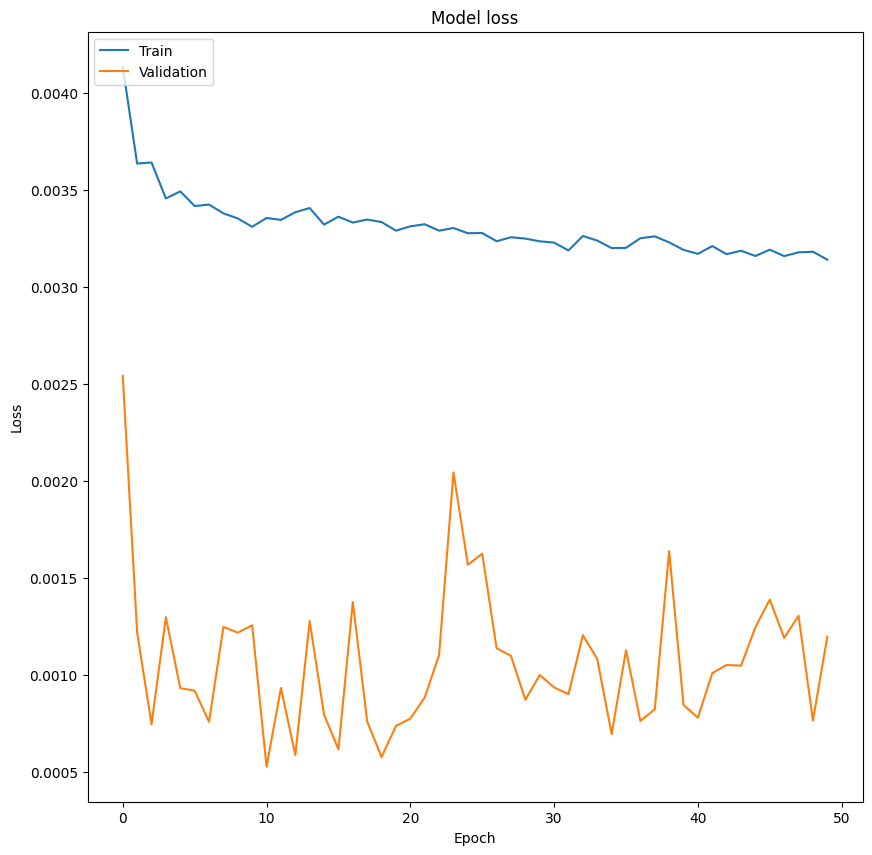

In [301]:
history = model.fit(x_t, y_t,
          batch_size=32, epochs=50, verbose=1,
          validation_data=(trim_dataset(x_val, BATCH_SIZE), 
                           trim_dataset(y_val, BATCH_SIZE)))

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [302]:
model.save('HW6_oneday.h5')

In [303]:
##To load the model
## model = load_model('HW6_oneday.h5')

In [304]:
predicted = model.predict(trim_dataset(x_val, BATCH_SIZE))
display(predicted)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


array([[0.06483549],
       [0.07658136],
       [0.06795355],
       [0.06689388],
       [0.06328259],
       [0.0668335 ],
       [0.06720228],
       [0.0645799 ],
       [0.0681714 ],
       [0.07013197],
       [0.06874898],
       [0.06779986],
       [0.06439067],
       [0.06400002],
       [0.06288352],
       [0.06204216],
       [0.06218695],
       [0.06166909],
       [0.06167618],
       [0.06137807],
       [0.06290744],
       [0.06290587],
       [0.06252597],
       [0.06263109],
       [0.06229517],
       [0.06401221],
       [0.0650434 ],
       [0.06441856],
       [0.06321172],
       [0.06809945],
       [0.08031614],
       [0.10031313],
       [0.08501215],
       [0.07230365],
       [0.06641789],
       [0.06424411],
       [0.06310467],
       [0.06223992],
       [0.0628132 ],
       [0.06246185],
       [0.06158244],
       [0.06178204],
       [0.06122437],
       [0.06259386],
       [0.06423056],
       [0.06421132],
       [0.06349996],
       [0.062

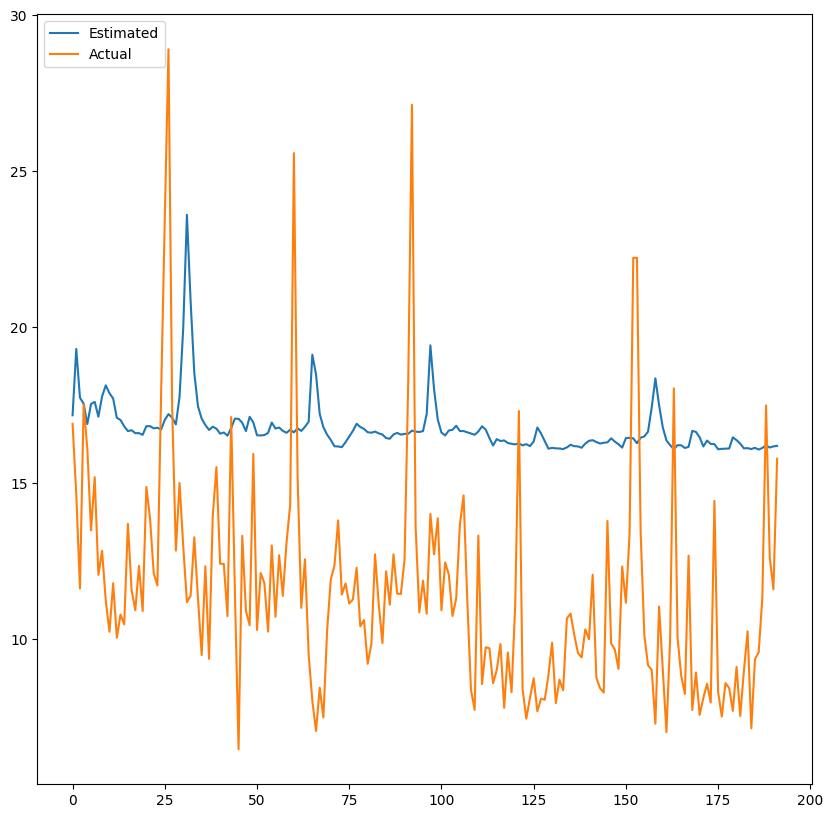

In [305]:
plt.figure()
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')